In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(sec:linear_simple)=
# Simple Linear Model

The simple linear model examines the relationship between two features, with one variable describing, explaining, or predicting the other. Tradition has us use the notation $x$ for the explanatory variable and $y$ for the outcome variable. Using this notation, the linear model is represented as 

$$
y \approx \theta_0 + \theta_1 x. 
$$

We interpret this model as follows: for a particular value of $x$, we explain or predict (depending on the setting) the outcome $y$ by the point on the line $\theta_0 + \theta_1 x$. As $x$ varies, the estimates for $y$ given $x$ fall on a line. Typically, the estimate isn't perfect, and there is some error in using the model; that's why we use the symbol $\approx$ above to mean "approximately". Additionally, we use $\hat{y}$ to represent this approximation. That is, 

$$
\hat{y} = \theta_0 + \theta_1 x.
$$

We often don't know the intercept and slope for the line so we estimate them using data, $(x_i, y_i)$ for $i=1,\ldots,n$. Again, we do not expect these pairs of data points to fall exactly along a line, but we do expect the scatter of points to be reasonably described by the line and the deviations between the $y_i$ and its estimate $\theta_0 + \theta_1 x_i$ to be roughly symmetrically distributed about the line with no apparent patterns. 

{numref}`Figure %s <fig:SLR>` shows this notion. On the left is a scatter plot of points with a line used to estimate $y$ from $x$. We mark two particular points by squares and their corresponding values on the line by diamonds. The dotted line from the actual point to the line shows the error. The plot on the right is a scatter plot of all of the errors; for reference, we marked the errors corresponding to the two square points in the left plot with squares as well.

```{figure} figures/scatterplotSLR.png
---
name: fig:SLR
width: 500px
---

A scatter plot of $(x_i, y_i)$ pairs, the simple line fitted to these points, and the deviations from the estimate $\theta_0 + \theta_1 x_i$, represented as triangles on the line, to $y_i$ for two example points.
```

The *sample correlation coefficient* measures the strength of the linear association between the $(x_i, y_i)$ pairs. Recall the definition:  

$$
\begin{aligned}
r({\mathbf{x}},{\mathbf{y}}) &= \sum_i \frac{(x_i - \bar{x})}{SD({\mathbf{x}})} \frac{(y_i - \bar{y})}{SD({\mathbf{y}})},
\end{aligned} 
$$

where ${\mathbf{x}}$ represents the observed $x$-values, $[x_1, \ldots, x_n]$ and $SD({\mathbf{x}})$ is their standard deviation. The notation $\mathbf{y}$ and $SD({\mathbf{y}})$ are similarly defined. 

The sample correlation measures how the $(x_i, y_i)$ pairs vary together. When all of the points fall exactly along a line, then the correlation is either $+1$ or $-1$, depending on whether the slope of the line is positive or negative. Two important features of the correlation coefficient:

+ $r$ is unitless. Notice that $x$, $\bar{x}$ and $SD({\mathbf{x}})$ all have the same units so the ratio below has no units (and likewise for the terms involving $y_i$):

$$
\frac{(x_i - \bar{x})}{SD({\mathbf{x}})}.
$$

+ $r$ measures the strength of a linear association, not whether or not the data have a linear association. The four scatter plots in {numref}`Figure %s <fig:AnscombeQuartet>` all have the same correlation coefficient of about $0.8$ (as well as the same averages and SDs), but only one plot, the one on the top right, has what we think of as a linear association with random errors about the line. This plot contains the same data as in {numref}`Figure %s <fig:SLR>`. 

```{figure} figures/AnscombeQuartet.svg
---
name: fig:AnscombeQuartet
width: 500px
---

Anscombe's quartet.
```

Linear models were first introduced in {numref}`Chapter %s <ch:pa>` where we used the relationship between measurements from high-quality air monitors operated by the Environmental Protection Agency and neighboring inexpensive air quality monitors to calibrate the inexpensive monitors for more accurate predictions. We revisit that example to make the notion of a simple linear model more concrete.  

## Example: A Simple Linear Model for Air Quality

In this example, we focus on air quality measurements at one location in Georgia. These are a subset of the data we examined in the case study in {numref}`Chapter %s <ch:pa>`. Recall, air quality is measured in terms of the counts of particles under 2.5 mm in size per cubic liter of air, and for each day, we have a pair of measurements from two nearby monitors, one made by PurpleAir and the other by a more accurate air quality system sensor operated by the EPA. These measurements are daily averages from August through October, 2019. 

In [2]:
csv_file = 'data/Full24hrdataset.csv'
usecols = ['Date', 'ID', 'region', 'PM25FM', 'PM25cf1']
full = (pd.read_csv(csv_file, usecols=usecols, parse_dates=['Date'])
        .dropna())
full.columns = ['date', 'id', 'region', 'pm25aqs', 'pm25pa']

#bad_dates = ['2019-08-21', '2019-08-22', '2019-09-24']
#GA = full.loc[(full['id'] == 'GA1') & (~full['date'].isin(bad_dates)) , :]

GA = full.loc[(full['id'] == 'GA1') , :]

#& (AK['pm25aqs'] < 30)

from sklearn.linear_model import LinearRegression

In [3]:
GA

,date,id,region,pm25aqs,pm25pa
5258,2019-08-02,GA1,Southeast,8.65,16.19
5259,2019-08-03,GA1,Southeast,7.70,13.59
5260,2019-08-04,GA1,Southeast,6.30,10.30
...,...,...,...,...,...
5439,2019-10-18,GA1,Southeast,6.30,12.94
5440,2019-10-21,GA1,Southeast,7.50,13.62
5441,2019-10-30,GA1,Southeast,5.20,14.55


The feature `pm25aqs` is taken from the EPA sensor and `pm25pa` from the PurpleAir monitor. We are interested in studying the relationship between these two features to better understand the accuracy of PurpleAir monitors. For this reason, we take the EPA readings as the explanatory variable, and the readings from the PurpleAir monitor as the outcome variable. We make a scatter plot of these two features. 

In [4]:
import statsmodels.formula.api as sm
from statsmodels.api import add_constant

result = sm.ols(formula="pm25pa ~ pm25aqs", data=GA).fit()

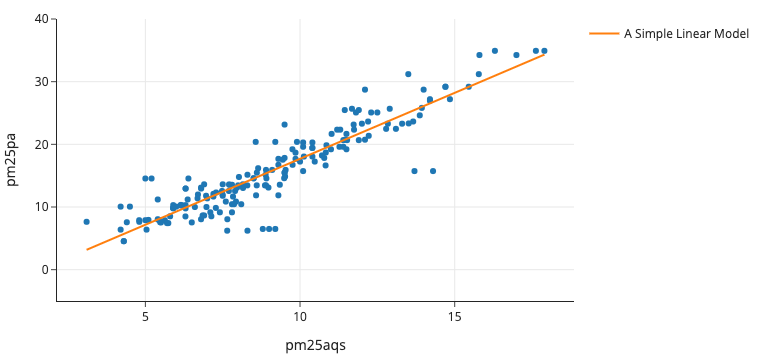

In [12]:
fig = px.scatter(GA, x="pm25aqs", y="pm25pa",
                 width=450, height=250)

pred_x = np.array([GA["pm25aqs"].min(), GA["pm25aqs"].max()])
pred_y = result.params[0] + result.params[1]* pred_x

fig.add_trace(go.Scatter(x=pred_x, y=pred_y,
                        name = "A Simple Linear Model", mode='lines'))

#fig.update_xaxes(range=[0, 20])
fig.update_yaxes(range=[-5, 40])

fig

The scatter plot shows a roughly linear relationship between these two air quality measurements. The line we added has the following intercept and slope:

In [15]:
print(f"Intercept: {result.params[0]:.1f} \nSlope {result.params[1]:.1f}")

Intercept: -3.4 
Slope 2.1


We can examine the errors in predicting $y_i$ using this line. Below, we plot these errors against the predicted values for each observation. The errors are on the $y$-axis; these are the differences: $y_i - \hat{y}_i$, where $\hat{y}_i = -3.4 + 2.1 x_i$ is the prediction. The predicted values, the $\hat{y}_i$, are on the $x$-axis. That is, the points are $(\hat{y}_i, y_i - \hat{y}_i)$ are plotted below. 

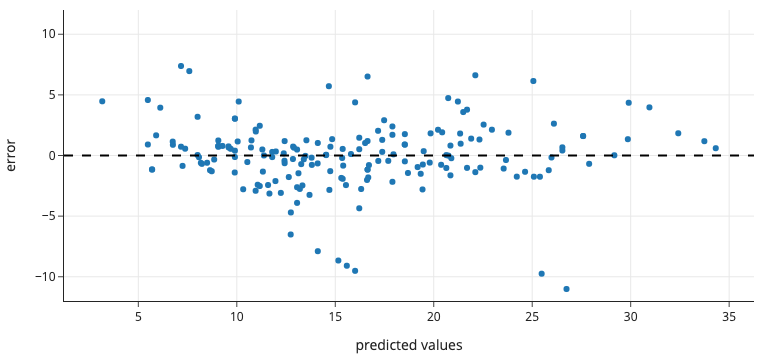

In [16]:
predicted = result.fittedvalues
errors = result.resid

fig = px.scatter(y = errors, x=predicted,
                 labels={
                     "y": "error",
                     "x": "predicted values"},
                 width=350, height=250)

fig.update_yaxes(range=[-12, 12])

fig.add_hline(0, line_color='black', line_width=2, line_dash='dash', opacity=1)

An error of $0$ means that $y_i$ falls on the line, a positive value means $y_i$ is above the line, and negative means it's below. You might be wondering how good this model is, and what it says about our data. This is the topic of the next section. 

## Interpreting Linear Models

Notice that the PurpleAir measurements are often quite a bit higher than the more accurate sensor measurements. Indeed, the equation for our simple line model has a slope of about 2.1:

$$\hat{y} = -3.4 + 2.1 x$$

Here, $x$ is the EPA sensor measurement and $\hat{y}$ is the prediction for the PurpleAir measurement for $x$.
We interpret the model as saying: a change of 1 ppm measured by the EPA monitor is associated with a 2.1 change in the PurpleAir measurement, on average. So, if on one day the EPA sensor measures 10 ppm and on the next day it is 5 ppm higher, namely 15 ppm, then our prediction for the PurpleAir measurement is $2.1 * 5 = 10.5$ppm higher on the new day. 

This $10.5$ ppm change in the Purple Air reading is not caused by the change in the EPA reading. Rather, they both reflect the air quality, and our model captures the relationship between the two devices. Often times the term *prediction* is taken to mean *causation*, but that is ofteen not the case. Instead, the prediction just refers to an *association* between the explanatory variable and the outcome. 

As for the intercept in the model, we might expect it to be 0, for if the accurate sensor measures 0 ppm then we would think that the PurpleAir device would also measure 0. The model instead, predicts $-3.4$ ppm, which doesn't quite make sense. There can't be negative amounts of particles in the air. Clearly, we need to be cautious about using this model for small values of $x$. On the other hand, forcing the linear model to have an intercept of 0 doesn't fix things. The line doesn't fit the data as well, and the predictions are worse for most observed values of $x$. If you're curious, we walk through the process of finding the linear model with a $0$ intercept in the Exercises. 

George Box, a renowned statistician, famously said, "all models are wrong, but some are useful." Here is a case where despite the intercept of the line not passing through $0$, the simple linear model is useful in predicting  air quality measurements for a PurpleAir sensor. Indeed, the correlation between our two features is very high.  

In [244]:
GA.corr().round(2)

,pm25aqs,pm25pa
pm25aqs,1.00,0.92
pm25pa,0.92,1.00


The *residual plot* we made earlier gives a visual assessment of the quality of the fit. A good fit will show a cloud of points around the y=0 line with no clear pattern. When there is a clear pattern, we can usually conclude that the simple linear model doesn't entirely capture the relationship between the features. We saw earlier that there are no apparent patterns in our residual plot. 

Other types of residual plots that can be useful in a visual assessment of the model are plots the residuals against a feature that was not included in the model. If we see a pattern then we may want to include this additional feature in the model. That is, we may want to fit a multiple linear model. For these particular data, since the measurements are daily averages over a two month period, we want to check whether there are any patterns in time. To do this, we plot the errors against time.   

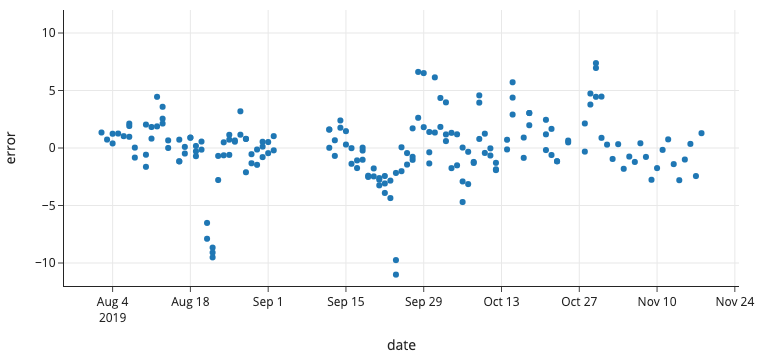

In [17]:
fig = px.scatter(x= GA["date"], y=errors, 
                 labels={
                     "y": "error",
                     "x": "date"},
                 width=350, height=250)

fig.update_yaxes(range=[-12, 12])
fig

It looks like there were a few consecutive days near the end of August and again near the end of September when the data were far below what was expected. Looking back at the original scatter plot and the first residual plot, see these observations as two clusters of horizontal points below the main point cloud. The plot we just made indicates that we should check the original data and any available information about the equipment to determine whether it was properly functioning on those days.

The residual plot can also give us a general sense of how accurate
the model is with its predictions.
Most of the residuals lie between $\pm 5$ppm of the line.
And, we find the standard deviation of the errors to be about 2.8 ppm:

In [19]:
np.std(errors)

2.788487426081143

This error may be reduced, if we find the monitor wasn't working on those days in late August and September and exclude them from the dataset. In any event, for situations where the air is quite clean, the error is relatively large, but in absolute terms inconsequential. We are typically more concerned about the case when there is air pollution, and there an error of $2.8$ppm seems reasonable.  

The simple linear model that we have been using is actually the line closest to the data. By "close" we mean in the sense of minimizing the errors. The process of finding this line is called *model fitting*. In the next section, we show how to fit this model using a loss function.   